# Teach Your Laptop to Trade Stock Options.
# Notebook 6: Use a LIME to Analyze a Single Prediction.
01/05/2021

In the previous notebook we reviewed several methods to analyze feature importance from the Learner point of view. Since the Learner is doing the prediction, we might argue that the Learner's point of view is the only view that counts.

However, feature importance has a big limitation. It applies to the features over the entire data set. Suppose that a Learner makes life or death decisions and got 997 correct predictions out of 1,000 trials. Then 997 people are delighted, but three (the false positives) are pretty darn unlucky. Those three people might want us to drill down into how/why the Learner made the wrong decision in those three specific predictions. 

OK, life or death predictions may be a little extreme, even though medical experts already use ML to analyze X-ray images to find cancerous tumors. 

More broadly, we want to develop trust in the model by 

For this notebook, let's use LIME to analyze the false positives and false negatives (FP and FN) for the covered call option trades in the previous notebooks in this series. Why the concern about FPs and FNs? If we are trading the predictions, then the FPs and FNs are where we lose money. If we trade every prediction, then we make money on every true positive (TP) prediction. The Learner predicted the trade would close positive and it did. We made a profit. For every true negative (TN) prediction the Learner predicted the trade would close at a loss and it did. By avoiding that trade, we did not lose money. 

But, when the Learner predicted thetrade would close positive and it did not, clearly a FP, we lost money making that trade. With a FN, we lost the opportunity to make money. So we have a strong motivation to understand how/why the Learner made the FP and FN predictions. For analysis of specific predictions, we cannot use tools and metrics that analyze all predictions. We need a tool that drills deep into individual predictions.

In this notebook we use LIME to analyze specific FP and FN predictions to understand how/why the Learner failed to predict correctly. With this knowledge, perhaps we can improve the input feature set to correct those errors. At the least, perhaps we can identify the types of situations that cause FPs and avoid those.


## Purpose of this Notebook - Analyze Specific FP and FN Predictions with LIME. 
As you already know from previous notebooks in this series, this data set is a set of option trades for covered calls. All the trades are short covered calls for XOM through the period 2017. The Learners predict which trades (short covered calls) will be profitable.

What You Need: Basic knowledge of Python, pandas, numpy, dataframes, and statistics. 

What You Don't Need: Knowledge of LIME, stock options, scipy, sklearn, or Machine Learning. This project is self-contained and you will learn as you go.

You will Learn:

- What is the structure of LIME.
- How to use LIME to analyze how the Learners used each feature to generate predictions for specific instances or trials. 
- How to compare predictions from different learners for specific instances using LIME.


## 1. Load the feature set and train the Learners.

These steps are covered in detail in notebook 3, so for this exercise we will not discuss in detail.


In [1]:
import pandas as pd
import numpy as np
training_features = pd.DataFrame()
training_features = pd.read_csv('training_features_wlabel.csv', index_col = False)


## 2. Set up the Learner Function. 

In [2]:
# Import ML Libraries from SKLearn.

import lightgbm
from lightgbm import LGBMClassifier as LGBMC

from sklearn import svm
from sklearn import metrics

from sklearn.decomposition     import PCA
from sklearn.preprocessing     import StandardScaler
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.neural_network    import MLPClassifier
from sklearn.ensemble          import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.datasets          import make_classification
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.neural_network    import MLPClassifier
from sklearn.naive_bayes       import GaussianNB 
from sklearn.feature_selection import SelectKBest
import xgboost
from xgboost                   import XGBClassifier
import catboost
from catboost                  import CatBoostClassifier
from sklearn.feature_selection import chi2

import time
import random

def RunLearners(Xr_train, Xr_test, yr_train, yr_test, all_run_stats, stats_columns, run_ID):
    print() 
    print('Please be patient. Some of these Learners are pretty slow learners.')
    print('If you get impatient, put in a print statement to show progress, or just use one already in place.')
    print()
    
    learners = {#'SVC sigmoid'      : svm.SVC(kernel = 'sigmoid'),
                #'SVC linear'       : svm.SVC(kernel = 'linear'),
                #'SVC poly'         : svm.SVC(kernel = 'poly'),
                #'GaussianNB'       : GaussianNB(),
                'MLPerceptron'     : MLPClassifier(alpha=1, max_iter=1000),
                'AdaBoost'         : AdaBoostClassifier(),
                #'RandomForest_d6'  : RandomForestClassifier(max_depth=3, random_state=97),
                #'KNNeighbors_2'    : KNeighborsClassifier(n_neighbors=3),
                'KNNeighbors_8'    : KNeighborsClassifier(n_neighbors=8),
                'GradientBoost'    : GradientBoostingClassifier(),
                'RandomForest_d12' : RandomForestClassifier(max_depth=12, random_state=97),
                'XGBoost'          : XGBClassifier(random_state = 97),
                'CatBoost'         : CatBoostClassifier(verbose = False, iterations = 300),
                'LightGBoost'      : LGBMC()
               }
    
    learner_types = learners.keys()
    for learner in learner_types: 
        print(learner ,'is learning now.')   
        clf = learners[learner]
        start_time = time.time()  
        clf.fit(Xr_train, yr_train)
        end_time = time.time()
        
        train_time = end_time - start_time
        start_time = time.time()  
        yr_pred = clf.predict(X_test)
        end_time = time.time()
        predict_time = end_time - start_time
        
        #Performance Metrics
        accuracy       = metrics.accuracy_score(yr_test, yr_pred)
        precision      = metrics.average_precision_score(yr_test, yr_pred)
        recall         = metrics.recall_score(yr_test, yr_pred, labels=None, pos_label=1, 
                                         average='binary', sample_weight=None, zero_division='warn')
        F1_score       = metrics.f1_score(yr_test, yr_pred, labels=None, pos_label=1, average='binary', 
                                     sample_weight=None, zero_division='warn')
        tn, fp, fn, tp = metrics.confusion_matrix(yr_test, yr_pred, labels=None, sample_weight=None, normalize=None).ravel()
        mcc            = metrics.matthews_corrcoef(yr_test, yr_pred, sample_weight=None)
        
        learner_metrics_dict = {'Learner'  : [learner],
                                'Accuracy' : [accuracy],
                                'Precision': [precision], 
                                'Recall'   : [recall],
                                'MCC'      : [mcc],
                                'True Neg' : [tn],
                                'False Pos': [fp], 
                                'False Neg': [fn], 
                                'True Pos' : [tp],
                                'Train Time': [train_time],
                                'Predict Time': [predict_time], 
                                'Run_ID'      : [run_ID]
                               }
                
        this_run_stats = pd.DataFrame(data = learner_metrics_dict)         
        all_run_stats = all_run_stats.append(this_run_stats)
    return all_run_stats

print()
print('No output yet. Call this function with a set of train and test features.')



No output yet. Call this function with a set of train and test features.


In [6]:
# Prepare the test and train data sets.
from sklearn.model_selection import train_test_split

train_dataset_df = pd.DataFrame()
test_dataset_df  = pd.DataFrame()

train_dataset_df  = pd.read_csv('opt_sample.csv', index_col = 0)
test_dataset_df = pd.read_csv('opt_test.csv', index_col = 0)
option_dataset = 


stats_columns = ['Learner', 'Accuracy', 'Precision', 'Recall', 'MCC',
                 'True Neg', 'False Neg', 'True Pos', 'False Pos', 'Train Time', 'Predict Time', 'Run_ID']

learner_stats = pd.DataFrame(columns = stats_columns)


y_train = train_dataset_df[['label']].to_numpy()
y_train = y_train.ravel()
print('y_train shape = ', y_train.shape)
X_train = train_dataset_df.drop(labels = 'label', axis = 'columns')
print('X_train shape = ', X_train.shape)

test_dataset_df = pd.read_csv('opt_test.csv', index_col = 0)
y_test = test_dataset_df[['label']].to_numpy()
X_test = test_dataset_df.drop(labels = 'label', axis = 'columns')

y_train = np.ravel(y_train)
y_test  = np.ravel(y_test)
print('y_train shape = ', y_train.shape)
run_ID = 'Initial'

learner_stats = RunLearners(X_train, X_test, y_train, y_test, learner_stats, stats_columns, run_ID)
learner_stats['sample count'] = learner_stats['True Neg']  + learner_stats['True Pos'] + \
                                learner_stats['False Neg'] + learner_stats['False Pos']
print()
print(learner_stats)
learner_stats.to_csv('learner_stats.csv')

y_train shape =  (5577,)
X_train shape =  (5577, 28)
y_train shape =  (5577,)

Please be patient. Some of these Learners are pretty slow learners.
If you get impatient, put in a print statement to show progress, or just use one already in place.

MLPerceptron is learning now.


AttributeError: 'DataFrame' object has no attribute 'accuracy_score'

## 6. Plot and Compare Performance of the Learners.



<AxesSubplot:>

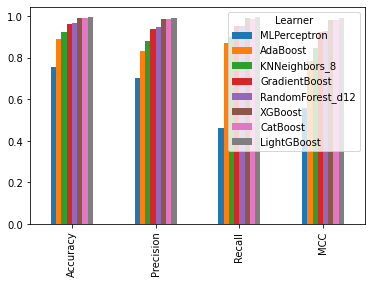

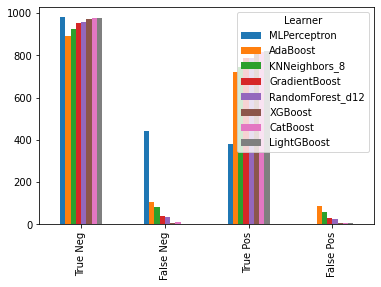

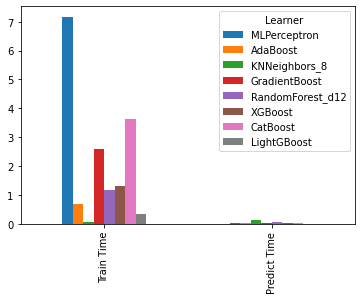

In [5]:

stats_for_plot = learner_stats.set_index('Learner', inplace=False, verify_integrity=False)
stats_xp = stats_for_plot.transpose(copy = True)
drop_rows = ['True Neg', 'False Pos', 'False Neg', 'True Pos', 'Train Time', 'Predict Time', 'Run_ID', 'sample count']
metrics = stats_xp.drop(labels = drop_rows, axis = 0, inplace = False)
metrics.plot.bar()

drop_rows = ['Accuracy', 'Precision', 'Recall', 'MCC','Train Time', 'Predict Time', 'Run_ID', 'sample count']
confusion = stats_xp.drop(labels = drop_rows, axis = 0, inplace = False)
confusion.plot.bar()

drop_rows = ['Accuracy', 'Precision', 'Recall', 'MCC', 'True Neg', 'False Pos', 'False Neg', \
             'True Pos', 'Run_ID', 'sample count']
speed = stats_xp.drop(labels = drop_rows, axis = 0, inplace = False)
speed.plot.bar()



## What's a LIME?
LIME (Local Interpretable Model-agnostic Explanations) is a method to create locally accurate explanations of how a Learner makes a prediction.

LIME creates a linear model of a Learner around a specific point in feature space. Like a tangent of a circle, the straight line approximation is exactly correct at that point in feature space, then diverges more and more as the sample points move away from the initial point. LIME as that Machine Learning is often accused of being a black box. While this may be a valid criticism,many Learners have built-in methods to present their internal metrics for features, sort of like human insights into what they learned. In this section we will use some methods for several Learners to understand how they actually used the features to get such impressive results.

In [ ]:
import lime
import lime.lime_tabular
import matplotlib
import matplotlib.pyplot as plt

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
feature_names = xgb_model.get_booster().feature_names

explainer = lime.lime_tabular.LimeTabularExplainer(np_training_data, 
                                                   mode='classification',training_labels_df,feature_names)


# asking for explanation for LIME model
instance = 1
exp = explainer.explain_instance(df_titanic.loc[instance,feat].astype(int).values, prob, num_features=20)

importance_types = ['weight', 'gain', 'cover']
for importance_metric in importance_types:
    xgboost.plot_importance(xgb_model, importance_type = importance_metric, max_num_features = 20)
    plot_title = 'XGBoost Feature Importance by '+ importance_metric
    plt.title(plot_title)
    plt.show()
    scores = xgb_model.feature_importances_

    
    sorted_index = xgb_model.feature_importances_.argsort()
    print(sorted_index)
    print(xgb_model.feature_importances_[sorted_index])
#    print(feature_names[sorted_index])
#plt.barh(boston.feature_names[sorted_idx], xgb.feature_importances_[sorted_idx])
#    plt.barh(xgb_model.feature_importances_[sorted_index])

The charts show features scores and rankings based on internal mesurements by XGBoost for weight, gain, and cover. 

Weight is the number of times the feature was used to split.
Gain is the information gain (decrease in entropy) as a result of each split.
Cover is the number or percent of samples to which the rule applies (covers).

These metrics are not mutually exclusive. In fact, their interrelatinoships are very rich. Consider the feature ER-Expiry, which ranked 1 (most important) in weight, 9 in gain, and 10 in cover. Without diving into the details of ER-Expiry, describe the characteristics of a feature which would exhibit this behavior. It must be used in many splits, but contribute only an average gain, and cover only an average number of samples. So this type of feature must be powerful primarily in conjunction with other features. 

Consider the SMA features: 30 day SMA, 15 day SMA, and 45 day SMA. They ranked 1, 2, and 3 in gain and cover, but dropped to 9, 14, and 6 in weight. This pattern is just the opposite of the ranking for feature ER-Expiry. What characteristics do these features have in common?

Evaluation Questions - Understand the Model, er, Forest
Use sklearn methods to interrogate the model to answer these questions. 
- How many trees in this forest?
- How many rules in this forest?
- How many decision notes? Leaf nodes?

Evaluation Questions - Understand the metrics.
- What are the three metrics? Define each metric in your own words.
- In the units shown in the charts, what is the maximum value for weight, gain, and cover.
- Describe the characteristics of a feature that scores high on one metric and low on the other two.
- Give an example of a tree where a feature scores high / low on each metric.
- Can a single feature score high on all three metrics simultaneously? Why, or not?
- Why are these metrics so important for random forests?

Code Questions
- The numbers in the lower two charts are not formatted well. Please fix.
- How would you use all these metrics to prune the feature set? Now write the code.
- Run all the learners with your reduced feature set. Any performance differences? Why, or not?
    

## Shapley Additive Values
Shapley value is a weighted average of the marginal contributions of a featrure value to the prediction in different coalitions (combinations) of features.

Shapley value is NOT a change in the prediciton when the feature is removed.

Shapley value has exhibits critical characteristics:
-Efficiency - feature contributions must sum to:
        delta(pred(x)) - average(predictions).
-Symmetry - If feature values i and j contribute equally to all possible coalitions, then Shapley value (i) = Shapley value (j).
-Dummy - If feature j contributes 0 to the prediction (no change in the prediction), then its Shapley value must be = 0.
-Additivity - for the payouts value + value*, Shapley value = x(j) + x(j*)

Problem with Shapley is a computational explosion--2^k coalitions.   

## Congratulations, you peeked inside the Learners with a real data set.

Congratulations! You just trained several Learners to pick winning stock option trades. Now, you are almost ready to make a fortune in the stock market. But, first... consider these questions:

- How can you improve the feature set? 
- Which Learner(s) would you choose? Why?
- How can you gain more confidence in your trader?
- What is your goal? Single profitable trades, or a portfolio of trades? What's the difference?

Tune into the next exciting notebook to explore questions of maximizing portfolio results for options trading. 

Wishing you only profitable trades and good learning,

Richard Barrett

richard at rbshomes dot com.

P.S. I want to hear about your adventures in Machine Learning, your questions and comments about stock option trading, and especially your specific applications for machine learning. Just shoot me an email.
